# Triplet CNN Batch-Hard

In [1]:
%autosave 0

Autosave disabled


In [1]:
# Python Imaging Library
from PIL import Image    
import PIL.ImageOps

# Packages
import torch
from torch.utils.data import DataLoader,Dataset
from torch import optim     # 包含optimization algorithms
import torch.nn.functional as F     # 包含activation functions
from torch.autograd import Variable      # 以Variable形式嵌套激励函数 
import torch.nn as nn

# Torchvision 包含目前流行的数据集，模型结构和常用的图片转换工具等
import torchvision
import torchvision.datasets as dset    # 包含一些数据集
import torchvision.transforms as transforms  # 可对PIL.Image, Tensor进行变换
import torchvision.utils  ##

# Others
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import linecache
import seaborn as sns

In [2]:
class Config():
    training_dir = "./Datasets/att/training/"
    validation_dir = "./Datasets/att/validamulti/"
    testing_dir = "./Datasets/att/testing/"
    batch_ap_path = 'batch_ap_mixed.txt'
    batch_an_path = 'batch_an_mixed.txt'
    batch_ap_hard_path = './batch_ap_hard_mixed.txt'
    batch_an_hard_path = './batch_an_hard_mixed.txt'
    train_batch_size = 32           #批样本数
    train_number_epoch = 400     #整批训练次数，即遍历了多少次所有的训练样本

In [3]:
def imshow(img, text=None, should_save=False):     #数据集出图
    npimg = img.numpy()   #转numpy
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold',
                bbox={'facecolor':'white','alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
        
def show_plot(iteration, loss):                    #观察迭代损失
    plt.plot(iteration, loss)
    plt.xlabel('Iteration number')
    plt.ylabel('Loss')
    plt.show

## generate mini-batch

Generate all possible AP and AN in mini_batch, and add an all-zero "helper pic" in order to input into the TriNet. 
Write into a .txt to be loaded by DataLoader.

In [4]:
def MiniBatchAllPairs(data_path, batch_ap_path, batch_an_path, num_class):
    helper_path = './ceshi/pic_helper.png'
    name_list = os.listdir(data_path)
    name_list.sort()
    batch_name = random.sample(name_list, num_class)
    print(batch_name)
    batch_ap = []
    for k in range(len(batch_name)):
        name = batch_name[k]
        path1 = data_path + name + '/'
        pic_list1 = os.listdir(path1)
        pic_list1.sort()
        for i in range(len(pic_list1)):
            anchor_pic = pic_list1[i]
            anchor_pic = path1 + anchor_pic
            for j in range(len(pic_list1)):
                if i!= j:
                    positive_pic = pic_list1[j]
                    positive_pic = path1 + positive_pic
                    pic_pair1 = anchor_pic + '\t' + positive_pic + '\t' + helper_path
                    batch_ap.append(pic_pair1)
    
    fileObject = open(batch_ap_path, 'w')  
    for pic_pair1 in batch_ap:  
        fileObject.write(pic_pair1)  
        fileObject.write('\n')  
    fileObject.close()
    
    batch_an = []
    for k in range(len(batch_name)):
        name = batch_name[k]
        path1 = data_path + name + '/'
        pic_list2 = os.listdir(path1)
        pic_list2.sort()
        for i in range(len(pic_list2)):
            anchor_pic = pic_list2[i]
            anchor_pic = path1 + anchor_pic
            for j in range(len(batch_name)):
                name_other = batch_name[j]
                path2 = data_path + name_other + '/'
                pic_list3 = os.listdir(path2)
                pic_list3.sort()
                if j != k :
                    for q in range(len(pic_list3)):
                        negative_pic = pic_list3[q]
                        negative_pic = path2 + negative_pic
                        pic_pair2 = anchor_pic + '\t'+ negative_pic + '\t' + helper_path
                        batch_an.append(pic_pair2)

    fileObject = open(batch_an_path, 'w')  
    for pic_pair2 in batch_an:  
        fileObject.write(pic_pair2)  
        fileObject.write('\n')  
    fileObject.close()

In [6]:
class_batch_size = 3    
MiniBatchAllPairs(data_path = Config.training_dir,  
                  batch_ap_path = Config.batch_ap_path, 
                  batch_an_path = Config.batch_an_path, 
                  num_class = class_batch_size)

['s29', 's26', 's18']


## Loaders

In [5]:
def pil_loader(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('L')

def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)

def default_loader(path):
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)

## Load A-P-helper Triplet 

Triplet网络要求三个输入，这里我们利用一个全1图像作为“helper”

In [6]:
class GetBatchPairs_AP(Dataset):
    def __init__(self, img_path, txt_path, data_transforms=None, loader = default_loader):
        with open(txt_path) as input_file:
            lines = input_file.readlines()
            self.img_anchor = [os.path.join(img_path, line.strip().split('\t')[0]) for line in lines]
            self.img_sample = [os.path.join(img_path, line.strip().split('\t')[1]) for line in lines]   
            self.img_helper = [os.path.join(img_path, line.strip().split('\t')[2]) for line in lines]
        self.data_transforms = data_transforms
        self.loader = loader

    def __len__(self):
        return len(self.img_helper)

    def __getitem__(self, item):
        img_anchor = self.img_anchor[item]
        img_sample = self.img_sample[item]
        img_helper = self.img_helper[item]
        img_a = self.loader(img_anchor)
        img_s = self.loader(img_sample)
        img_h = self.loader(img_helper)
        
        if self.data_transforms is not None:
            try:
                img_a = self.data_transforms(img_a)
            except:
                print("Cannot transform image: {}".format(img_a))
            try:
                img_s = self.data_transforms(img_s)
            except:
                print("Cannot transform image: {}".format(img_s))
            try:
                img_h = self.data_transforms(img_h)
            except:
                print("Cannot transform image: {}".format(img_h))   
                
        return img_a, img_s, img_h
    

## Load A-helper-N triplets

In [7]:
class GetBatchPairs_AN(Dataset):
    def __init__(self, img_path, txt_path, data_transforms=None, loader = default_loader):
        with open(txt_path) as input_file:
            lines = input_file.readlines()
            self.img_anchor = [os.path.join(img_path, line.strip().split('\t')[0]) for line in lines]
            self.img_sample = [os.path.join(img_path, line.strip().split('\t')[1]) for line in lines]   
            self.img_helper = [os.path.join(img_path, line.strip().split('\t')[2]) for line in lines]
        self.data_transforms = data_transforms
        self.loader = loader

    def __len__(self):
        return len(self.img_helper)

    def __getitem__(self, item):
        img_anchor = self.img_anchor[item]
        img_sample = self.img_sample[item]
        img_helper = self.img_helper[item]
        img_a = self.loader(img_anchor)
        img_s = self.loader(img_sample)
        img_h = self.loader(img_helper)
        
        if self.data_transforms is not None:
            try:
                img_a = self.data_transforms(img_a)
            except:
                print("Cannot transform image: {}".format(img_a))
            try:
                img_s = self.data_transforms(img_s)
            except:
                print("Cannot transform image: {}".format(img_s))
            try:
                img_h = self.data_transforms(img_h)
            except:
                print("Cannot transform image: {}".format(img_h))    
                
        return img_a, img_h, img_s

## Load Triplets  (the Batch-Hardest ones)

In [8]:
class GetBatchHardest(Dataset):
    def __init__(self, img_path, txt_path1, txt_path2, data_transforms=None, loader = default_loader):
        with open(txt_path1) as input_file1:
            lines = input_file1.readlines()
            self.img_anchor = [os.path.join(img_path, line.strip().split('\t')[0]) for line in lines]
            self.img_positi = [os.path.join(img_path, line.strip().split('\t')[1]) for line in lines]   
        with open(txt_path2) as input_file2:
            lines = input_file2.readlines()
            self.img_negati = [os.path.join(img_path, line.strip().split('\t')[1]) for line in lines]   
        self.data_transforms = data_transforms
        self.loader = loader

    def __len__(self):
        return len(self.img_anchor)

    def __getitem__(self, item):
        img_anchor = self.img_anchor[item]
        img_positi = self.img_positi[item]
        img_negati = self.img_negati[item]
        img_a = self.loader(img_anchor)
        img_p = self.loader(img_positi)
        img_n = self.loader(img_negati)
        
        if self.data_transforms is not None:
            try:
                img_a = self.data_transforms(img_a)
            except:
                print("Cannot transform image: {}".format(img_a))
            try:
                img_p = self.data_transforms(img_p)
            except:
                print("Cannot transform image: {}".format(img_s))
            try:
                img_n = self.data_transforms(img_n)
            except:
                print("Cannot transform image: {}".format(img_h))    
                
        return img_a, img_p, img_n

## Visualizing some APH

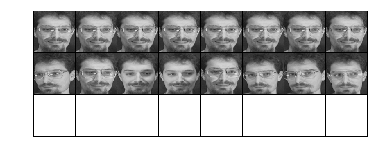

In [9]:
batch_ap_datasets = GetBatchPairs_AP(img_path='./',
                            txt_path=('./batch_ap_mixed.txt'),
                            data_transforms=transforms.Compose([transforms.Resize((100,100)),
                                                                     transforms.ToTensor()
                                                                     ]),
                            )
ap_dataloaders = DataLoader(batch_ap_datasets,
                        batch_size=8,
                        shuffle=False)
ap_data_iter = iter(ap_dataloaders)    #生成迭代器

example_batch = next(ap_data_iter)     #返回迭代器的下一个项目
concatenated = torch.cat((example_batch[0],example_batch[1],example_batch[2]),0)  #张量拼接，0：按行，1：按列
imshow(torchvision.utils.make_grid(concatenated))

## Visualizing some AHN

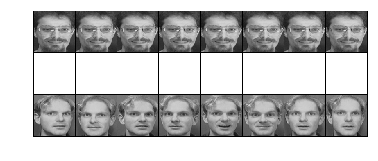

In [10]:
batch_an_datasets = GetBatchPairs_AN(img_path='./',
                            txt_path=('./batch_an_mixed.txt'),
                            data_transforms=transforms.Compose([transforms.Resize((100,100)),
                                                                     transforms.ToTensor()
                                                                     ]),
                            )
an_dataloaders = DataLoader(batch_an_datasets,
                        batch_size=8,
                        shuffle=False)
an_data_iter = iter(an_dataloaders)    #生成迭代器

example_batch = next(an_data_iter)     #返回迭代器的下一个项目
concatenated = torch.cat((example_batch[0],example_batch[1],example_batch[2]),0)  #张量拼接，0：按行，1：按列
imshow(torchvision.utils.make_grid(concatenated))

## Triplet CNN

In [11]:
class TripletNetwork(nn.Module):                 # torch.nn.Module:所有神经网络模块的基类
    def __init__(self):
        super(TripletNetwork, self).__init__()
        self.cnn1 = nn.Sequential(               # torch.nn.Sequential:模块将按照在构造器中的顺序传递
            nn.ReflectionPad2d(1),               # 使用输入边界的反射来填充输入张量
            nn.Conv2d(                           # 对信号（由若干输入平面组成）进行2维卷积
                in_channels=1,                   # input height. 灰度图1层，RGB为3层，即图像的通道数
                out_channels=4,                  # n_filters 过滤器数目，过滤器提取的特征数
                kernel_size=3,                   # 卷积核 filter size 3x3
                stride=1,                        # filter movement/step 跳度
                padding=0,                       # 零填充。若想要con2d出来的图片长宽没有变化，当stride=1,padding=(kernel_size-1)/2
            ),
            nn.ReLU(inplace=True),               # ReLU(x)=max(0,x), inplace不是很懂
            nn.BatchNorm2d(4),                   # 对4维输入应用批标准化（一个小批量的2维输入和额外的通道尺寸）？
            nn.Dropout2d(p=.2),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(
                in_channels=4,
                out_channels=8,
                kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),
        )
        
        self.fc1 = nn.Sequential(                   # fc full connected
            nn.Linear(in_features=8*100*100,        # 线性层,y=Ax+b
                      out_features=500),
            nn.ReLU(inplace=True),
            
            nn.Linear(500,500),
            nn.ReLU(inplace=True),
            
            nn.Linear(500,50)
    )
    
    def forward_once(self,x):
        output = self.cnn1(x)
        output = output.view(output.size()[0],-1)   #Morvan说是展平多维的卷积图。check:http://pytorch.org/docs/master/tensors.html?highlight=view#torch.Tensor.view
        output = self.fc1(output)
        return output
    
    def forward(self, input1, input2, input3):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        output3 = self.forward_once(input3)
        return output1,output2,output3
    
net = TripletNetwork()
print(net)

TripletNetwork(
  (cnn1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace)
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True)
    (4): Dropout2d(p=0.2)
    (5): ReflectionPad2d((1, 1, 1, 1))
    (6): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace)
    (8): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True)
    (9): Dropout2d(p=0.2)
    (10): ReflectionPad2d((1, 1, 1, 1))
    (11): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (12): ReLU(inplace)
    (13): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True)
    (14): Dropout2d(p=0.2)
  )
  (fc1): Sequential(
    (0): Linear(in_features=80000, out_features=500, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=500, out_features=50, bias=True)
  )
)


## Online Training!

In [12]:
net.load_state_dict(torch.load('tri_batch_mixed_params.pkl'))

In [15]:
# criterion = F.triplet_margin_loss()   
optimizer = optim.Adam(net.parameters(), lr = 0.0005)
counter = []
loss_history = [] 
iteration_number= 0
class_batch_size = 5
alpha = 0.2

In [18]:
for epoch in range(0,Config.train_number_epoch):
# for epoch in range(0,100):


#先筛选batch内hardest a-p
    MiniBatchAllPairs(data_path = Config.training_dir,  
                  batch_ap_path = Config.batch_ap_path, 
                  batch_an_path = Config.batch_an_path, 
                  num_class = class_batch_size)
    batch_ap_datasets = GetBatchPairs_AP(img_path = './',
                                         txt_path = Config.batch_ap_path,
                                         data_transforms=transforms.Compose([transforms.Resize((100,100)),
                                                                             transforms.ToTensor()
                                                                            ])
                                        )

    gethard_ap_dataloader = DataLoader(batch_ap_datasets,
                            shuffle=False,
                            batch_size=1)

    eu_dist_np = np.array([])
    batch_ap_hard = []
    for i, data in enumerate(gethard_ap_dataloader,0):                        
        img0, img1 , img2 = data
        img0, img1 , img2 = Variable(img0), Variable(img1) , Variable(img2)
        output1,output2,output3 = net(img0,img1,img2)
        eu_distance = F.pairwise_distance(output1, output2)
        eu_dist = eu_distance.cpu().data.numpy()[0][0]
    #     print(i,eu_dist)
        eu_dist_np = np.append(eu_dist_np,eu_dist)
        if i!= 0 and (i+1)%9 == 0:
            hardest_num = np.argmax(eu_dist_np)
            hardest_num = i - 8 + int(hardest_num)    #hardest pair position
            linecache.updatecache(Config.batch_ap_path)      #神坑，linecache会缓存首次打开的txt，导致输出一直是首次batch
            hardest_ap_line = linecache.getline(Config.batch_ap_path,hardest_num+1)
            hardest_ap_line = hardest_ap_line.split()
            hardest_ap_line = hardest_ap_line[0] + '\t' + hardest_ap_line[1]
    #         print(hardest_ap_line)
            batch_ap_hard.append(hardest_ap_line)
            eu_dist_np = np.array([])
        
    fileObject = open(Config.batch_ap_hard_path, 'w')                   #写入txt
    for hardest_ap in batch_ap_hard:
        fileObject.write(hardest_ap)  
        fileObject.write('\n')  
    fileObject.close()

    
#筛选batch内hardest a-n
    batch_an_datasets = GetBatchPairs_AN(img_path='./',
                                         txt_path=Config.batch_an_path,
                                         data_transforms=transforms.Compose([transforms.Resize((100,100)),
                                                                         transforms.ToTensor()
                                                                   ]),
                                        )
    gethard_an_dataloader = DataLoader(batch_an_datasets,
                        shuffle=False,
                        batch_size=1)
    eu_dist_np = np.array([])
    batch_an_hard = []


    for i, data in enumerate(gethard_an_dataloader,0):               #
        img0, img1 , img2 = data
        img0, img1 , img2 = Variable(img0), Variable(img1) , Variable(img2)
        output1,output2,output3 = net(img0,img1,img2)
        eu_distance = F.pairwise_distance(output1, output3)
        eu_dist = eu_distance.cpu().data.numpy()[0][0]
    #     print(i,eu_dist)
        eu_dist_np = np.append(eu_dist_np,eu_dist)
        if i!= 0 and (i+1)%(10*(class_batch_size-1)) == 0:
            hardest_num = np.argmin(eu_dist_np)
            hardest_num = i - (10*(class_batch_size-1)-1) + int(hardest_num)    #hardest pair position
            linecache.updatecache(Config.batch_an_path)
            hardest_an_line = linecache.getline(Config.batch_an_path,hardest_num+1)
            hardest_an_line = hardest_an_line.split()
            hardest_an_line = hardest_an_line[0] + '\t' + hardest_an_line[1]
#             print(hardest_an_line)
            batch_an_hard.append(hardest_an_line)
            eu_dist_np = np.array([])
        
    fileObject = open(Config.batch_an_hard_path, 'w')
    for hardest_an in batch_an_hard:
        fileObject.write(hardest_an)  
        fileObject.write('\n')  
    fileObject.close()

#对batch内每个样本生成hardest a-p-n 即hardest triplet,进行训练
    batch_hard_datasets = GetBatchHardest(img_path='./',
                                          txt_path1=Config.batch_ap_hard_path,
                                          txt_path2=Config.batch_an_hard_path,
                                          data_transforms=transforms.Compose([transforms.Resize((100,100)),
                                                                              transforms.ToTensor()
                                                                             ])
                                          )

    hard_dataloaders = DataLoader(batch_hard_datasets,
                        batch_size=30,
                        num_workers=4,
                        shuffle=True)

    for i, data in enumerate(hard_dataloaders,0):
        img0, img1 , img2 = data
        img0, img1 , img2 = Variable(img0), Variable(img1) , Variable(img2)
        output1,output2,output3 = net(img0,img1,img2)
        optimizer.zero_grad()
        loss_triplet = F.triplet_margin_loss(output1,output2,output3,margin=alpha)
        loss_triplet.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch: {} | Current loss {}\n".format(epoch,loss_triplet.data[0]))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_triplet.data[0])
        
        
    torch.save(net.state_dict(),'tri_batch_mixed_params.pkl')
show_plot(counter,loss_history)
        
        

['s21', 's18', 's16', 's12', 's14']
Epoch: 0 | Current loss 0.030405282974243164

['s20', 's15', 's19', 's03', 's13']
Epoch: 1 | Current loss 0.0

['s26', 's08', 's04', 's05', 's11']
Epoch: 2 | Current loss 0.0654628723859787

['s17', 's27', 's30', 's04', 's19']
Epoch: 3 | Current loss 0.07086878269910812

['s04', 's07', 's20', 's06', 's16']
Epoch: 4 | Current loss 0.026382509618997574

['s13', 's30', 's23', 's07', 's27']
Epoch: 5 | Current loss 0.0

['s04', 's08', 's03', 's17', 's20']
Epoch: 6 | Current loss 0.0

['s04', 's20', 's18', 's01', 's09']
Epoch: 7 | Current loss 0.004483095835894346

['s09', 's26', 's11', 's10', 's19']
Epoch: 8 | Current loss 0.008712577633559704

['s20', 's06', 's02', 's13', 's29']
Epoch: 9 | Current loss 0.047465451061725616

['s02', 's05', 's12', 's06', 's27']
Epoch: 10 | Current loss 0.0317845493555069

['s15', 's25', 's20', 's12', 's18']
Epoch: 11 | Current loss 0.0

['s06', 's09', 's01', 's18', 's26']
Epoch: 12 | Current loss 0.007823816500604153

['s1

KeyboardInterrupt: 

In [ ]:
torch.save(net.state_dict(),'tri_batch_mixed_params.pkl')

In [19]:
net.load_state_dict(torch.load('tri_batch_mixed_params.pkl'))

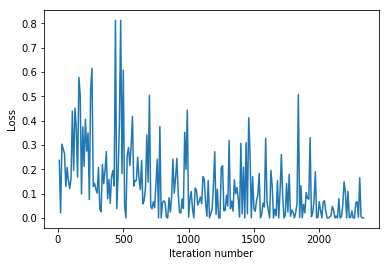

In [28]:
show_plot(counter,loss_history)

## Distribution

In [13]:
class TripletNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)   #在self...imgs中返回随机项
        # 先取A-P对，保持循环，直到找到相同的类的图像
        while True:
            img1_tuple = random.choice(self.imageFolderDataset.imgs)   #元组=（图片路径，类编号）
            if img0_tuple[1] == img1_tuple[1]:                         #图片编号相同则是同一个类（以文件夹区分）
                break
        # 再取A-N
        while True:
            img2_tuple = random.choice(self.imageFolderDataset.imgs)
            if img0_tuple[1] != img2_tuple[1]:
                break

        img0 = Image.open(img0_tuple[0])    #读取实际图像，tuple[0]即路径
        img1 = Image.open(img1_tuple[0])
        img2 = Image.open(img2_tuple[0])
        img0 = img0.convert("L")            #from PIL，把img转换为256级灰度图像， L：8-bit pixels,black and white
        img1 = img1.convert("L")
        img2 = img2.convert("L")

        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)    #将输入图像转换为反色图像
            img1 = PIL.ImageOps.invert(img1)
            img2 = PIL.ImageOps.invert(img2)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
        return img0, img1, img2
            #返回 img0,img1,img2，完成A-P-N组合
    
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)          #数据集大小

观察训练集分布

In [14]:
folder_dataset_train = dset.ImageFolder(root=Config.training_dir)
triplet_dataset = TripletNetworkDataset(imageFolderDataset=folder_dataset_train,
                                       transform=transforms.Compose([transforms.Resize((100,100)),
                                                                    transforms.ToTensor()
                                                                    ]),
                                       should_invert=False)

train_distri_dataloader = DataLoader(triplet_dataset, 
                             num_workers=6, 
                             batch_size=1, 
                             shuffle=True)



same_one_train = np.array([])
diff_one_train = np.array([])


for i, data in enumerate(train_distri_dataloader, 0):   #将一个可遍历的数据对象组合为一个索引序列，同时列出数据和数据下标
    img0, img1, img3 = data
    img0, img1, img3 = Variable(img0), Variable(img1), Variable(img3)
    output1, output2, output3 = net(img0, img1,img3)   # network output
    eu_distance_same = F.pairwise_distance(output1, output2)
    eu_dist_same = eu_distance_same.cpu().data.numpy()[0][0]
    eu_distance_diff = F.pairwise_distance(output1, output3)
    eu_dist_diff = eu_distance_diff.cpu().data.numpy()[0][0]
    same_one_train = np.append(same_one_train, eu_dist_same)
    diff_one_train = np.append(diff_one_train, eu_dist_diff)    


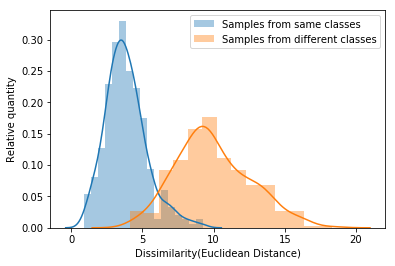

In [15]:
sns.distplot(same_one_train, 
             #bins=20, 
             rug=False, 
             hist=True,
            label='Samples from same classes')
sns.distplot(diff_one_train, 
             #bins=20, 
             rug=False, 
             hist=True,
            label='Samples from different classes')
plt.xlabel('Dissimilarity(Euclidean Distance)')
plt.ylabel('Relative quantity')
plt.legend()
plt.show()

验证集分布

In [28]:
folder_dataset_valida = dset.ImageFolder(root=Config.validation_dir)
triplet_dataset = TripletNetworkDataset(imageFolderDataset=folder_dataset_valida,
                                       transform=transforms.Compose([transforms.Resize((100,100)),
                                                                    transforms.ToTensor()
                                                                    ]),
                                       should_invert=False)

valida_distri_dataloader = DataLoader(triplet_dataset, 
                             num_workers=6, 
                             batch_size=1, 
                             shuffle=True)



same_one_valida = np.array([])
diff_one_valida= np.array([])


for i, data in enumerate(valida_distri_dataloader, 0):   #将一个可遍历的数据对象组合为一个索引序列，同时列出数据和数据下标
    img0, img1, img3 = data
    img0, img1, img3 = Variable(img0), Variable(img1), Variable(img3)
    output1, output2, output3 = net(img0, img1,img3)   # network output
    eu_distance_same = F.pairwise_distance(output1, output2)
    eu_dist_same = eu_distance_same.cpu().data.numpy()[0][0]
    eu_distance_diff = F.pairwise_distance(output1, output3)
    eu_dist_diff = eu_distance_diff.cpu().data.numpy()[0][0]
    same_one_valida = np.append(same_one_valida, eu_dist_same)
    diff_one_valida = np.append(diff_one_valida, eu_dist_diff)

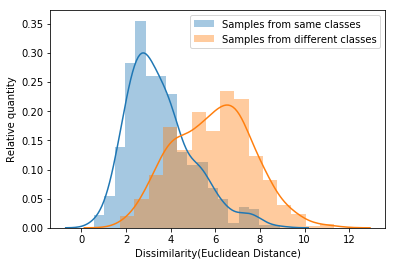

In [29]:
sns.distplot(same_one_valida, 
             #bins=20, 
             rug=False, 
             hist=True,
            label='Samples from same classes')
sns.distplot(diff_one_valida, 
             #bins=20, 
             rug=False, 
             hist=True,
            label='Samples from different classes')
plt.xlabel('Dissimilarity(Euclidean Distance)')
plt.ylabel('Relative quantity')
plt.legend()
plt.show()

## ROC

In [21]:
tpr_array = np.array([])
fpr_array = np.array([])
same_one_valida = np.array([])
diff_one_valida = np.array([])


for thres in range(0,140,2):
    print(thres)
    tpm = 0
    fpm = 0
    tp_fn = 0
    fp_tn = 0
    for i, data in enumerate(valida_distri_dataloader, 0):
        img0, img1, img2 = data
        img0, img1, img2 = Variable(img0), Variable(img1), Variable(img2)
        output1, output2, output3 = net(img0, img1, img2)   # network output
        eu_distance_ap = F.pairwise_distance(output1, output2)
        eu_dist_ap = eu_distance_ap.cpu().data.numpy()[0][0]
        eu_distance_an = F.pairwise_distance(output1, output3)
        eu_dist_an = eu_distance_an.cpu().data.numpy()[0][0]
        
        tp_fn = tp_fn + 1
        fp_tn = fp_tn + 1
        
        if eu_dist_ap < (thres/10):
            tpm = tpm + 1
            
        if eu_dist_an < (thres/10):
            fpm = fpm + 1

    try:
        tpr=tpm/tp_fn
    except:
        print("still 0")
    else:
        tpr_array = np.append(tpr_array,tpr)
    try:
        fpr=fpm/fp_tn
    except:
        print("still 0")
    else:
        fpr_array = np.append(fpr_array,fpr)
    

0
2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50
52
54
56
58
60
62
64
66
68
70
72
74
76
78
80
82
84
86
88
90
92
94
96
98
100
102
104
106
108
110
112
114
116
118
120
122
124
126
128
130
132
134
136
138


In [22]:
print(tp_fn,fp_tn,tpm,fpm)
len(fpr_array)
x = fpr_array
y = tpr_array 
sia_adam_roc = (x,y)
sia_adam_roc


480 480 480 480


(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00416667,
        0.00416667, 0.00416667, 0.02708333, 0.0125    , 0.03958333,
        0.04583333, 0.0625    , 0.06666667, 0.09583333, 0.10833333,
        0.13541667, 0.1875    , 0.17916667, 0.23958333, 0.25416667,
        0.30416667, 0.31458333, 0.39375   , 0.40833333, 0.46875   ,
        0.49583333, 0.59583333, 0.62916667, 0.65416667, 0.7       ,
        0.73333333, 0.79791667, 0.7875    , 0.79583333, 0.88541667,
        0.88541667, 0.9       , 0.9125    , 0.93333333, 0.94791667,
        0.96875   , 0.96875   , 0.97291667, 0.98125   , 0.98125   ,
        0.99166667, 0.9875    , 0.98958333, 0.99791667, 1.        ,
        0.99583333, 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 0.99791667, 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ]),
 array([0.        , 0.        , 0.        , 0.

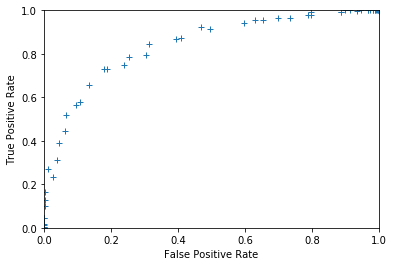

0.8423111979166666


In [23]:
x = sia_adam_roc[0]
y = sia_adam_roc[1]

# This is the ROC curve
plt.plot(x,y,'+')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# This is the AUC
auc = np.trapz(y,x)
print(auc)

测试集分布

In [25]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
triplet_dataset = TripletNetworkDataset(imageFolderDataset=folder_dataset_test,
                                       transform=transforms.Compose([transforms.Resize((100,100)),
                                                                    transforms.ToTensor()
                                                                    ]),
                                       should_invert=False)

test_distri_dataloader = DataLoader(triplet_dataset, 
                             num_workers=6, 
                             batch_size=1, 
                             shuffle=True)



same_one_test = np.array([])
diff_one_test = np.array([])


for i, data in enumerate(valida_distri_dataloader, 0):   #将一个可遍历的数据对象组合为一个索引序列，同时列出数据和数据下标
    img0, img1, img3 = data
    img0, img1, img3 = Variable(img0), Variable(img1), Variable(img3)
    output1, output2, output3 = net(img0, img1,img3)   # network output
    eu_distance_same = F.pairwise_distance(output1, output2)
    eu_dist_same = eu_distance_same.cpu().data.numpy()[0][0]
    eu_distance_diff = F.pairwise_distance(output1, output3)
    eu_dist_diff = eu_distance_diff.cpu().data.numpy()[0][0]
    same_one_test = np.append(same_one_test, eu_dist_same)
    diff_one_test = np.append(diff_one_test, eu_dist_diff)

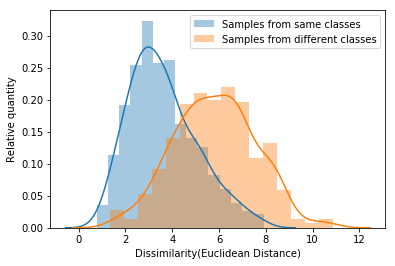

In [26]:
sns.distplot(same_one_test, 
             #bins=20, 
             rug=False, 
             hist=True,
            label='Samples from same classes')
sns.distplot(diff_one_test, 
             #bins=20, 
             rug=False, 
             hist=True,
            label='Samples from different classes')
plt.xlabel('Dissimilarity(Euclidean Distance)')
plt.ylabel('Relative quantity')
plt.legend()
plt.show()

## 功能测试

In [ ]:
%%time
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
triplet_dataset = TripletNetworkDataset(imageFolderDataset=folder_dataset_test,
                                       transform=transforms.Compose([transforms.Resize((100,100)),
                                                                    transforms.ToTensor()
                                                                    ]),
                                       should_invert=False)

test_dataloader = DataLoader(triplet_dataset, num_workers=6, batch_size=1, shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

threshold = 4.95

for i in range(10):
    x0, x1, x2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    output1, output2, output3 = net(Variable(x0), Variable(x1),Variable(x2))     #Variable(x0).cuda()
    eu_distance = F.pairwise_distance(output1, output2)
    eu_dist = eu_distance.cpu().data.numpy()[0][0]
    if eu_dist <= threshold:
        imshow(torchvision.utils.make_grid(concatenated),
           'Dissimilarity:{:.2f}\nSame One!'.format(eu_dist))
    else:
        imshow(torchvision.utils.make_grid(concatenated),
           'Dissimilarity:{:.2f}\nDifferent Ones!'.format(eu_dist))    